In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy
import jaxopt

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import src.ksdagg as src_ksdagg
import experiments.kef as exp_kef
import experiments.efm as exp_efm
import experiments.rbm as exp_rbm

In [3]:
n = 100
dim = 50
res_stats = pickle.load(open(f"../data/bw/stats_n{n}_d{dim}.pkl", "rb"))

bw_ls = list(res_stats.keys())
print(bw_ls)
ol_ls = list(res_stats[bw_ls[0]].keys())
print(ol_ls)
eps_ls = list(res_stats[bw_ls[0]][ol_ls[0]].keys())
print(eps_ls)

['med', 0.01, 0.1, 1.0, 10.0, 100.0]
[0.0, 0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2]
['standard', 'tilted', 'tilted_r_boot', 'tilted_r_bootmax', 'theta', 'ksdagg']


In [8]:
methods = {"standard": "IMQ", "tilted_r_boot": "R-KSD-Boot"}

plot_df = {"eps": [], "method": [], "rej": [], "bw": [], "bw_order": []}
    
for bw in bw_ls[1:]:
    for eps in eps_ls:
        for m, m_label in methods.items():
            rr = res_stats[bw][eps][m]
            plot_df["eps"].extend([eps] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))
            plot_df["bw"].extend([bw] * len(rr["nonsq_stat"]))
            plot_df["bw_order"].extend([np.round(np.log(bw) / np.log(10.), 2)] * len(rr["rej"]))

plot_df = pd.DataFrame(plot_df)

# med heuristic
med_plot_df = {"eps": [], "method": [], "rej": []}
for eps in eps_ls:
    for m, m_label in methods.items():
        rr = res_stats["med"][eps][m]
        med_plot_df["eps"].extend([eps] * len(rr["rej"]))
        
        med_plot_df["rej"].extend(rr["rej"])
        med_plot_df["method"].extend(["med"] * len(rr["rej"]))

med_plot_df = pd.DataFrame(med_plot_df)

# ksdagg
ksdagg_plot_df = {"eps": [], "method": [], "rej": []}
for eps in eps_ls:
    rr = res_stats[bw_ls[0]][eps]["ksdagg"]
    ksdagg_plot_df["eps"].extend([eps] * len(rr["rej"]))
    
    ksdagg_plot_df["rej"].extend(rr["rej"])
    ksdagg_plot_df["method"].extend(["KSDAgg"] * len(rr["rej"]))

ksdagg_plot_df = pd.DataFrame(ksdagg_plot_df)

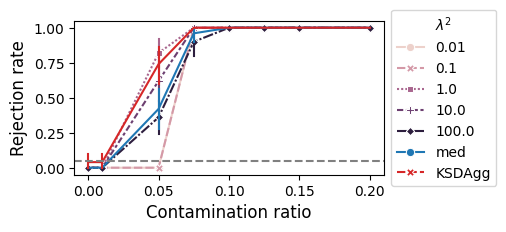

In [154]:
# _, axes = plt.subplots(ncols=len(eps0_ls), figsize=(3*len(eps0_ls), 2))
_, ax = plt.subplots(figsize=(4, 2))

g1 = sns.lineplot(ax=ax, data=plot_df, x="eps", y="rej", hue="bw_order", style="bw_order", markers=True, err_style="bars")
lines = ax.get_lines()
line_colors = [line.get_color() for line in lines]
g2 = sns.lineplot(ax=ax, data=med_plot_df, x="eps", y="rej", markers=True, err_style="bars", color="C0")
g3 = sns.lineplot(ax=ax, data=ksdagg_plot_df, x="eps", y="rej", markers=True, err_style="bars", color="C3")
# ax.axvline(eps0, color="k", linestyle="-.", label=r"$\epsilon_0$")
ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
ax.set_xlabel("Contamination ratio", fontsize=12)
ax.set_ylabel("Rejection rate", fontsize=12)

lg = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), labels=bw_ls[1:]+["med", "KSDAgg"], title=r"$\lambda^2$")
lg.get_lines()[-2].set_color("C0")
lg.get_lines()[-1].set_color("C3")

plt.savefig("../figs/robust/bw.pdf", bbox_extra_artists=(lg,), bbox_inches="tight")

In [116]:
X_res = pickle.load(open(f"../data/bw/X_res_n{n}_d{dim}.pkl", "rb"))

In [130]:
X = X_res[eps_ls[6]][0]
kernel = kernels.RBF(med_heuristic=True, X=X, Y=X)
kernel.sigma_sq / 2.

Array(53.353546, dtype=float32)

# vs. outlier

In [9]:
n = 100
dim = 50
res_stats = pickle.load(open(f"../data/bw/ol_stats_n{n}_d{dim}.pkl", "rb"))

bw_ls = list(res_stats.keys())
print(bw_ls)
ol_ls = list(res_stats[bw_ls[0]].keys())
print(ol_ls)
eps_ls = list(res_stats[bw_ls[0]][ol_ls[0]].keys())
eps_ls

['med', 0.01, 0.1, 1.0, 10.0, 100.0]
[0.1, 1.0, 10.0, 25.0, 50.0, 100.0]


[0.05]

In [10]:
methods = {"standard": "IMQ", "tilted_r_boot": "R-KSD-Boot"}
eps = eps_ls[0]

plot_df = {"ol": [], "method": [], "rej": [], "bw": [], "bw_order": []}
    
for bw in bw_ls[1:]:
    for ol in ol_ls:
        for m, m_label in methods.items():
            rr = res_stats[bw][ol][eps][m]
            # plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
            plot_df["ol"].extend([ol] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))
            plot_df["bw"].extend([bw] * len(rr["nonsq_stat"]))
            plot_df["bw_order"].extend([np.round(np.log(bw) / np.log(10.), 2)] * len(rr["rej"]))

plot_df = pd.DataFrame(plot_df)

# med heuristic
med_plot_df = {"ol": [], "method": [], "rej": []}
for ol in ol_ls:
    rr = res_stats["med"][ol][eps]["standard"]
    med_plot_df["ol"].extend([ol] * len(rr["rej"]))
    
    med_plot_df["rej"].extend(rr["rej"])
    med_plot_df["method"].extend(["med"] * len(rr["rej"]))

med_plot_df = pd.DataFrame(med_plot_df)

# ksdagg
ksdagg_plot_df = {"ol": [], "method": [], "rej": []}
for ol in ol_ls:
    rr = res_stats[bw_ls[0]][ol][eps]["ksdagg"]
    ksdagg_plot_df["ol"].extend([ol] * len(rr["rej"]))
    
    ksdagg_plot_df["rej"].extend(rr["rej"])
    ksdagg_plot_df["method"].extend(["KSDAgg"] * len(rr["rej"]))

ksdagg_plot_df = pd.DataFrame(ksdagg_plot_df)

In [19]:
plot_df.loc[(plot_df.method == m) & (plot_df.bw_order == -2)]

,ol,method,rej,bw,bw_order
50,0.1,R-KSD-Boot,1,0.01,-2.0
51,0.1,R-KSD-Boot,1,0.01,-2.0
52,0.1,R-KSD-Boot,1,0.01,-2.0
53,0.1,R-KSD-Boot,1,0.01,-2.0
54,0.1,R-KSD-Boot,1,0.01,-2.0
...,...,...,...,...,...
595,100.0,R-KSD-Boot,0,0.01,-2.0
596,100.0,R-KSD-Boot,0,0.01,-2.0
597,100.0,R-KSD-Boot,0,0.01,-2.0
598,100.0,R-KSD-Boot,0,0.01,-2.0


In [44]:
bw = 0.01
rr = res_stats[bw][0.1][eps]["tilted_r_boot"]

rr.keys()

dict_keys(['nonsq_stat', 'stat', 'u_stat', 'threshold', 'rej', 'theta', 'gamma', 'pval'])

In [49]:
X_res = pickle.load(open(f"../data/bw/ol_X_res_n{n}_d{dim}.pkl", "rb"))
score_res = pickle.load(open(f"../data/bw/ol_score_res_n{n}_d{dim}.pkl", "rb"))

ol = 0.1
Xs = X_res[ol][eps]
scores = score_res[ol][eps]

In [50]:
X = Xs[0]
score = scores[0]

kernel_args = {"sigma_sq": 2*bw}
weight_fn_args = {}

weight_fn = kernels.PolyWeightFunction(**weight_fn_args)
kernel0 = kernels.IMQ(**kernel_args)
kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=weight_fn)

ksd = metrics.KSD(kernel)
ustat = ksd(X, X, vstat=False, score=score)
thresh_res = ksd.test_threshold(
    n=X.shape[0], eps0=eps, theta=None, alpha=0.05, method="boot_both", X=X, score=score, 
    return_pval=True, compute_tau=True,
)

In [51]:
thresh_res["gram_mat"]

Array([[ 2.4752869e+03, -5.5041118e-04, -2.2137561e-04, ...,
        -7.3817186e-04,  2.5130552e-04, -8.2756835e-04],
       [-5.5041094e-04,  4.7362736e+01,  3.1369603e-03, ...,
        -6.1313307e-04,  1.1235932e-03, -3.5661757e-03],
       [-2.2137584e-04,  3.1369601e-03,  4.9025551e+01, ...,
         1.2595518e-03,  1.4071502e-03, -2.5968971e-03],
       ...,
       [-7.3817186e-04, -6.1313307e-04,  1.2595518e-03, ...,
         3.7611172e+01, -8.1489990e-05, -9.1027992e-04],
       [ 2.5130552e-04,  1.1235931e-03,  1.4071503e-03, ...,
        -8.1489990e-05,  5.0231033e+01, -3.5800214e-04],
       [-8.2756812e-04, -3.5661752e-03, -2.5968971e-03, ...,
        -9.1027992e-04, -3.5800214e-04,  4.7227707e+01]], dtype=float32)

In [57]:
q_degen_nonsq = thresh_res["q_degen_nonsq"]
vstat = thresh_res["vstat"]
nonsq_stat = vstat**0.5
theta = thresh_res["theta"]

print(max(0, nonsq_stat - theta) > q_degen_nonsq)
nonsq_stat - theta, q_degen_nonsq

False


(Array(0.09551167, dtype=float32), Array(2.1182854, dtype=float32))

In [58]:
vstat, rr["stat"][0]

(Array(6.672531, dtype=float32), Array(6.672531, dtype=float32))

In [67]:
theta, rr["theta"][0]

(Array(2.4876127, dtype=float32), Array(0.36742347, dtype=float32))

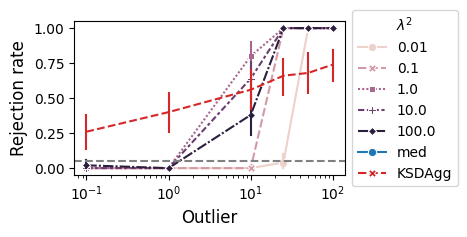

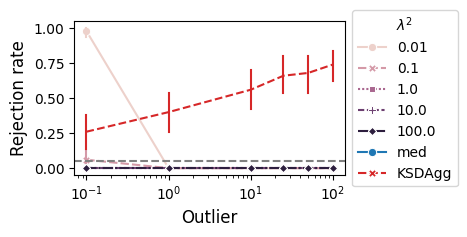

In [17]:
for m in methods.values():
    _, ax = plt.subplots(figsize=(3.5, 2))
    
    g1 = sns.lineplot(ax=ax, data=plot_df.loc[plot_df.method == m],
                      x="ol", y="rej", hue="bw_order", style="bw_order", markers=True, err_style="bars")
    g2 = sns.lineplot(ax=ax, data=med_plot_df.loc[med_plot_df.method == m], 
                      x="ol", y="rej", markers=True, err_style="bars", color="C0")
    g3 = sns.lineplot(ax=ax, data=ksdagg_plot_df, x="ol", y="rej", markers=True, err_style="bars", color="C3", linestyle="--")
    ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
    ax.set_xlabel("Outlier", fontsize=12)
    ax.set_ylabel("Rejection rate", fontsize=12)
    ax.set_xscale("log")
    
    lg = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), labels=bw_ls[1:]+["med", "KSDAgg"], title=r"$\lambda^2$")
    lg.get_lines()[-2].set_color("C0")
    lg.get_lines()[-1].set_color("C3")
    
    # plt.savefig("../figs/robust/bw.pdf", bbox_extra_artists=(lg,), bbox_inches="tight")

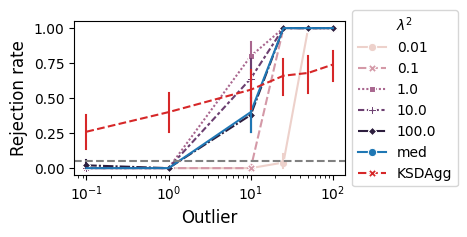

In [147]:
_, ax = plt.subplots(figsize=(3.5, 2))

g1 = sns.lineplot(ax=ax, data=plot_df, x="ol", y="rej", hue="bw_order", style="bw_order", markers=True, err_style="bars")
g2 = sns.lineplot(ax=ax, data=med_plot_df, x="ol", y="rej", markers=True, err_style="bars", color="C0")
g3 = sns.lineplot(ax=ax, data=ksdagg_plot_df, x="ol", y="rej", markers=True, err_style="bars", color="C3", linestyle="--")
ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
ax.set_xlabel("Outlier", fontsize=12)
ax.set_ylabel("Rejection rate", fontsize=12)
ax.set_xscale("log")

lg = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), labels=bw_ls[1:]+["med", "KSDAgg"], title=r"$\lambda^2$")
lg.get_lines()[-2].set_color("C0")
lg.get_lines()[-1].set_color("C3")

# plt.savefig("../figs/robust/bw.pdf", bbox_extra_artists=(lg,), bbox_inches="tight")

# vs. eps

In [118]:
n = 100
dim = 50
res_stats = pickle.load(open(f"../data/bw/eps_stats_n{n}_d{dim}.pkl", "rb"))

bw_ls = list(res_stats.keys())
print(bw_ls)
ol_ls = list(res_stats[bw_ls[0]].keys())
print(ol_ls)
eps_ls = list(res_stats[bw_ls[0]][ol_ls[0]].keys())
print(eps_ls)

['med', 0.01, 0.1, 1.0, 10.0, 100.0]
[10.0]
[0.0, 0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2]


In [119]:
methods = {"standard": "IMQ", "tilted_r_boot": "R-KSD"}
ol = ol_ls[0]

plot_df = {"eps": [], "method": [], "rej": [], "bw": [], "bw_order": []}
    
for bw in bw_ls[1:]:
    for eps in eps_ls:
        for m, m_label in methods.items():
            rr = res_stats[bw][ol][eps][m]
            # plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
            plot_df["eps"].extend([eps] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))
            plot_df["bw"].extend([bw] * len(rr["nonsq_stat"]))
            plot_df["bw_order"].extend([np.round(np.log(bw) / np.log(10.), 2)] * len(rr["rej"]))

plot_df = pd.DataFrame(plot_df)

# med heuristic
med_plot_df_ls = []
for m, m_label in methods.items():
    med_plot_df = {"eps": [], "method": [], "rej": []}
    for eps in eps_ls:
        rr = res_stats["med"][ol][eps][m]
        med_plot_df["eps"].extend([eps] * len(rr["rej"]))
        
        med_plot_df["rej"].extend(rr["rej"])
        med_plot_df["method"].extend(["med"] * len(rr["rej"]))
    
    med_plot_df_ls.append(pd.DataFrame(med_plot_df))

med_plot_df = med_plot_df_ls[0]
r_med_plot_df = med_plot_df_ls[1]

# ksdagg
ksdagg_plot_df = {"eps": [], "method": [], "rej": []}
for eps in eps_ls:
    rr = res_stats[bw_ls[0]][ol][eps]["ksdagg"]
    ksdagg_plot_df["eps"].extend([eps] * len(rr["rej"]))
    
    ksdagg_plot_df["rej"].extend(rr["rej"])
    ksdagg_plot_df["method"].extend(["KSDAgg"] * len(rr["rej"]))

ksdagg_plot_df = pd.DataFrame(ksdagg_plot_df)

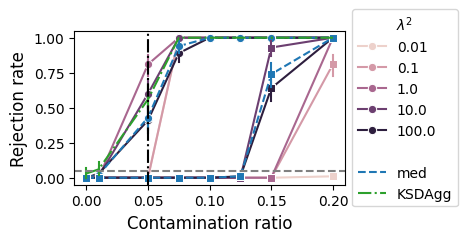

In [128]:
_, ax = plt.subplots(figsize=(3.5, 2))
styles = ["o", "s"]
# for s, m in zip(styles, methods.values()):
    
#     g1 = sns.lineplot(ax=ax, data=plot_df.loc[plot_df.method == m],
#                       x="eps", y="rej", hue="bw_order", style="method", markers=[s], err_style="bars")

g01 = sns.lineplot(ax=ax, data=plot_df.loc[plot_df.method == "IMQ"],
                  x="eps", y="rej", hue="bw_order", style="method", markers=["o"], err_style="bars")
g02 = sns.lineplot(ax=ax, data=med_plot_df, x="eps", y="rej", markers=True, err_style="bars", color="C0", linestyle="--", marker="o")

g1 = sns.lineplot(ax=ax, data=plot_df.loc[plot_df.method == "R-KSD"],
                  x="eps", y="rej", hue="bw_order", style="method", markers=["s"], err_style="bars")
g2 = sns.lineplot(ax=ax, data=r_med_plot_df, x="eps", y="rej", markers=True, err_style="bars", color="C0", linestyle="--", marker="s")

g3 = sns.lineplot(ax=ax, data=ksdagg_plot_df, x="eps", y="rej", markers=True, err_style="bars", color="C2", linestyle="-.")

ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
ax.axvline(0.05, color="k", linestyle="-.")
ax.set_xlabel("Contamination ratio", fontsize=12)
ax.set_ylabel("Rejection rate", fontsize=12)

# ax.legend()
lg = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), labels=bw_ls[1:]+["", "med", "KSDAgg"], title=r"$\lambda^2$")
lg.get_lines()[-2].set_color("C0")
lg.get_lines()[-2].set_linestyle("--")
lg.get_lines()[-1].set_color("C2")
lg.get_lines()[-1].set_linestyle("-.")

# plt.savefig("../figs/robust/bw.pdf", bbox_extra_artists=(lg,), bbox_inches="tight")

/tmp/ipykernel_1426243/529317455.py:12: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  lg = ax.legend([title_proxy, g01], ["a"]+bw_ls[1:], loc="center left", bbox_to_anchor=(1, 0.5), ncol=2)


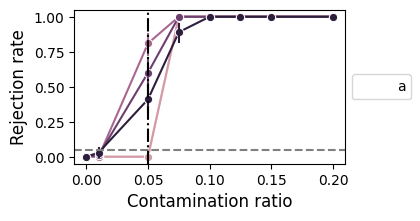

In [144]:
_, ax = plt.subplots(figsize=(3.5, 2))

g01 = sns.lineplot(ax=ax, data=plot_df.loc[plot_df.method == "IMQ"],
                  x="eps", y="rej", hue="bw_order", style="method", markers=["o"], err_style="bars")

ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
ax.axvline(0.05, color="k", linestyle="-.")
ax.set_xlabel("Contamination ratio", fontsize=12)
ax.set_ylabel("Rejection rate", fontsize=12)

title_proxy = Rectangle((0,0), 0, 0, color='w')
lg = ax.legend([title_proxy, g01], ["a"]+bw_ls[1:], loc="center left", bbox_to_anchor=(1, 0.5), ncol=2)
# lg = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), labels=bw_ls[1:]*2, title=r"$\lambda^2$")
# lg.get_lines()[-2].set_color("C0")
# lg.get_lines()[-2].set_linestyle("--")
# lg.get_lines()[-1].set_color("C2")
# lg.get_lines()[-1].set_linestyle("-.")

# plt.savefig("../figs/robust/bw.pdf", bbox_extra_artists=(lg,), bbox_inches="tight")

In [140]:
lg.get_lines()